In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

try:
    spark.close()
except: 
    pass

try:
    conf = SparkConf().setAppName('Spark Project')
    sc = SparkContext(conf=conf)
except Exception as e:
    print(e)
#.config("spark.some.config.option", "some-value") \
#SparkContext.setSystemProperty('spark.executor.memory', '8g')
#spark = SparkSession \
#    .builder \
#    .appName("Spark Project") \
#    .config("spark.executor.memory", '5g') \
#    .config("spark.driver.memory", '5g') \
#    .getOrCreate()

spark = SparkSession.builder \
    .appName("Spark Project") \
    .config("spark.executor.memory", "2000mb") \
    .master("local[*]") \
    .config("spark.executor.cores", "4") \
    .config("spark.yarn.executor.memoryOverhead",200) \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.default.parallelism", "6") \
    .getOrCreate()

df = spark.read.load("data/US_Accidents_Dec19.csv",format="csv", sep=",", inferSchema="true", header="true")

In [3]:
sc

<SparkContext master=local[*] appName=Spark Project>

In [4]:
sc._conf.getAll()

[('spark.default.parallelism', '6'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'Spark Project'),
 ('spark.executor.cores', '4'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.app.id', 'local-1588192817933'),
 ('spark.driver.port', '34267'),
 ('spark.driver.host', 'ae0d30820d9f'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.memory', '2000mb'),
 ('spark.yarn.executor.memoryOverhead', '200'),
 ('spark.ui.showConsoleProgress', 'true')]

# Imports

In [5]:
from pyspark.sql.functions import when, count, col, isnan, countDistinct,from_unixtime,from_utc_timestamp, unix_timestamp,split, to_timestamp, hour, month, lit,collect_list
import seaborn as sns 
import matplotlib.pyplot as plt 

# Due to problem in spark 3.0.0
spark.conf.set("spark.sql.legacy.utcTimestampFunc.enabled", "true")

# Define variables

In [6]:
# Define data information

# Numerical values

colLabel = ["Severity"]

colRem = ['ID', 
          'Source',
          'End_Time',
          'End_Lat',
          'End_Lng',
          'Description',
        ]

# Dropping data that cant help during model
df = df.drop(*colRem)

# Convert boolean to string since PCA cant handle boolean which should be a class
df = df.select(*[col(c[0]).cast("string").alias(c[0]) if c[1] == 'boolean' else col(c[0]).alias(c[0]) for c in df.dtypes])

#renamedHousing.select([count(when(col(c).isNull(), c)).alias(c) for c in colNum]).show()
rdd = sc.parallelize(df.dtypes)

colCat = rdd.map(lambda i: i[0] if (i[1]=='string' or i[1]=='boolean' and i[0]) else None).filter(lambda i: i != None).collect()
colNum = rdd.map(lambda i: i[0] if (i[1]=='double' and i[0]) else None).filter(lambda i: i != None).collect()

print(colCat)
print(colNum)

['Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
['TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']


# 1. Analysis

In [7]:
print(f"Categories:\n \
Labels: {len(colLabel)}\n \
Classes: {len(colCat)}\n \
Removed: {len(colRem)}\n \
Numerical: {len(colNum)}") 

print(f"Rows: {df.count()}\nColumns {len(df.columns)}")
df.printSchema()
df.take(1)

Categories:
 Labels: 1
 Classes: 28
 Removed: 6
 Numerical: 12
Rows: 2974335
Columns 43
root
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)

[Row(TMC=201.0, Severity=3, Start_Time=datetime.datetime(2016, 2, 8, 5, 46), Start_Lat=39.865147, Start_Lng=-84.058723, Distance(mi)=0.01, Number=None, Street='I-70 E', Side='R', City='Dayton', County='Montgomery', State='OH', Zipcode='45424', Country='US', Timezone='US/Eastern', Airport_Code='KFFO', Weather_Timestamp=datetime.datetime(2016, 2, 8, 5, 58), Temperature(F)=36.9, Wind_Chill(F)=None, Humidity(%)=91.0, Pressure(in)=29.68, Visibility(mi)=10.0, Wind_Direction='Calm', Wind_Speed(mph)=None, Precipitation(in)=0.02, Weather_Condition='Light Rain', Amenity='false', Bump='false', Crossing='false', Give_Way='false', Junction='false', No_Exit='false', Railway='false', Roundabout='false', Station='false', Stop='false', Traffic_Calming='false', Traffic_Signal='false', Turning_Loop='false', Sunrise_Sunset='Night', Civil_Twilight='Night', Nautical_Twilight='Night', Astronomical_Twilight='Night')]

## Statistical summary

In [8]:
df.describe(colNum).show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+--------------------+
|summary|               TMC|         Start_Lat|         Start_Lng|      Distance(mi)|            Number|   Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|  Wind_Speed(mph)|   Precipitation(in)|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+--------------------+
|  count|           2246264|           2974335|           2974335|           2974335|           1056730|          2918272|          1121712|           2915162|           2926193|          2908644|          2533495|              975977|
|   mean|207.83163198982845|36.493605002031636| -95.4262

## Get missing data

In [9]:
# Check data

df_missingVals_cols = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Missing value in each column
df_missingVals_cols.collect()

[Row(TMC=728071, Severity=0, Start_Time=0, Start_Lat=0, Start_Lng=0, Distance(mi)=0, Number=1917605, Street=0, Side=0, City=83, County=0, State=0, Zipcode=880, Country=0, Timezone=3163, Airport_Code=5691, Weather_Timestamp=36705, Temperature(F)=56063, Wind_Chill(F)=1852623, Humidity(%)=59173, Pressure(in)=48142, Visibility(mi)=65691, Wind_Direction=45101, Wind_Speed(mph)=440840, Precipitation(in)=1998358, Weather_Condition=65932, Amenity=0, Bump=0, Crossing=0, Give_Way=0, Junction=0, No_Exit=0, Railway=0, Roundabout=0, Station=0, Stop=0, Traffic_Calming=0, Traffic_Signal=0, Turning_Loop=0, Sunrise_Sunset=93, Civil_Twilight=93, Nautical_Twilight=93, Astronomical_Twilight=93)]

## Get categorical values

In [10]:
# Checking how many classes that can be used
df.agg(*(countDistinct(col(c)).alias(c) for c in colCat)).collect()[0].asDict()

{'Street': 160715,
 'Side': 3,
 'City': 11685,
 'County': 1713,
 'State': 49,
 'Zipcode': 377152,
 'Country': 1,
 'Timezone': 4,
 'Airport_Code': 1995,
 'Wind_Direction': 24,
 'Weather_Condition': 120,
 'Amenity': 2,
 'Bump': 2,
 'Crossing': 2,
 'Give_Way': 2,
 'Junction': 2,
 'No_Exit': 2,
 'Railway': 2,
 'Roundabout': 2,
 'Station': 2,
 'Stop': 2,
 'Traffic_Calming': 2,
 'Traffic_Signal': 2,
 'Turning_Loop': 1,
 'Sunrise_Sunset': 2,
 'Civil_Twilight': 2,
 'Nautical_Twilight': 2,
 'Astronomical_Twilight': 2}

## Correlation

In [11]:
print([*colNum, *colLabel])

['TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Severity']


In [12]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(
    inputCols=colNum,
    outputCol="features",
    handleInvalid = "skip")

df_attributes = assembler.transform(df)
df_attributes.select("features").show(1,False)



r1 = Correlation.corr(df_attributes, "features").head()

print("correlation matrix:\n" + str(r1[0]))

+---------------------------------------------------------------------------+
|features                                                                   |
+---------------------------------------------------------------------------+
|[201.0,39.972038,-82.913521,0.01,3280.0,37.4,33.8,100.0,29.62,3.0,4.6,0.02]|
+---------------------------------------------------------------------------+
only showing top 1 row

correlation matrix:
DenseMatrix([[ 1.00000000e+00, -3.29968079e-02, -4.23709318e-02,
               6.48521350e-02,  4.88102771e-02,  2.89427459e-02,
               3.07391705e-02, -6.70493470e-03,  4.59513996e-03,
               2.21819466e-02, -1.61669692e-03, -1.80310455e-03],
             [-3.29968079e-02,  1.00000000e+00, -5.22492702e-03,
               5.01751676e-02, -3.17558810e-02, -4.68351247e-01,
              -4.69159899e-01,  9.79378608e-02, -1.18202158e-01,
              -1.54998940e-01,  9.15359600e-02,  5.03876348e-03],
             [-4.23709318e-02, -5.22492702e-

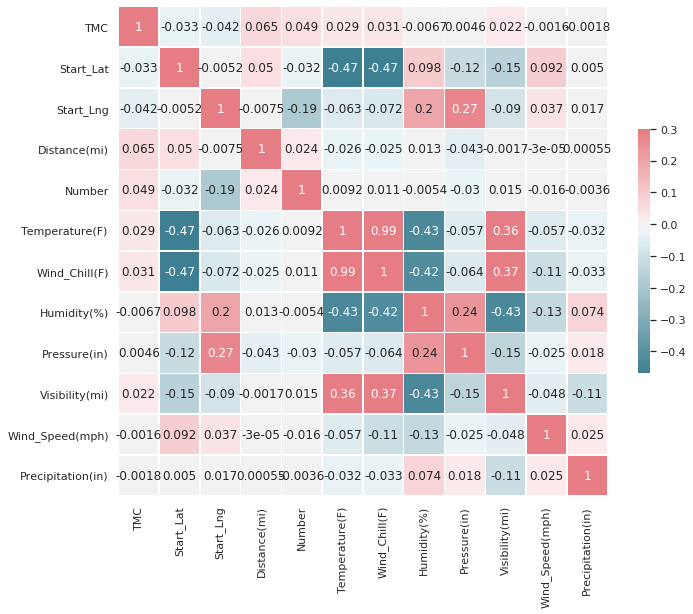

In [13]:
sns.set(style="white")

# Generate a large random dataset

# Compute the correlation matrix

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(r1, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(r1[0].toArray().tolist(), annot=True, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=colNum,yticklabels=colNum)

## Severity

In [14]:
severity_freq = df.groupBy('Severity').count().orderBy('count',ascending=False).collect()

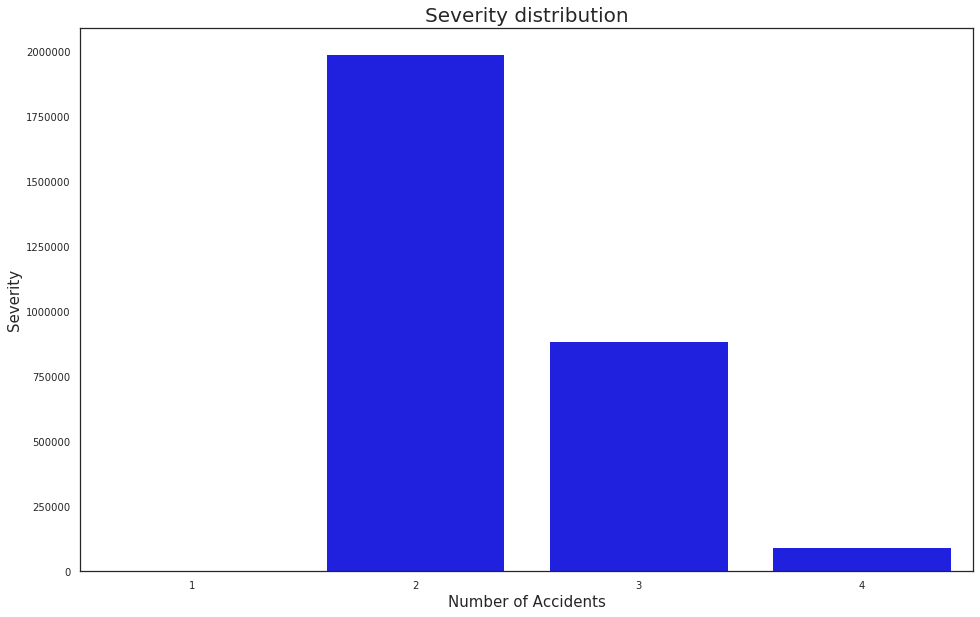

In [15]:
rdd = sc.parallelize(severity_freq)
pd_severity = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))
b = sns.barplot(pd_severity['Severity'],pd_severity['count'], color='blue')
b.axes.set_title("Severity distribution",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("Severity",fontsize=15)
b.tick_params(labelsize=10)

## Causes

### Frequency of severity and state

In [16]:
state_freq = df.groupBy('State').count().orderBy('count',ascending=False).collect()

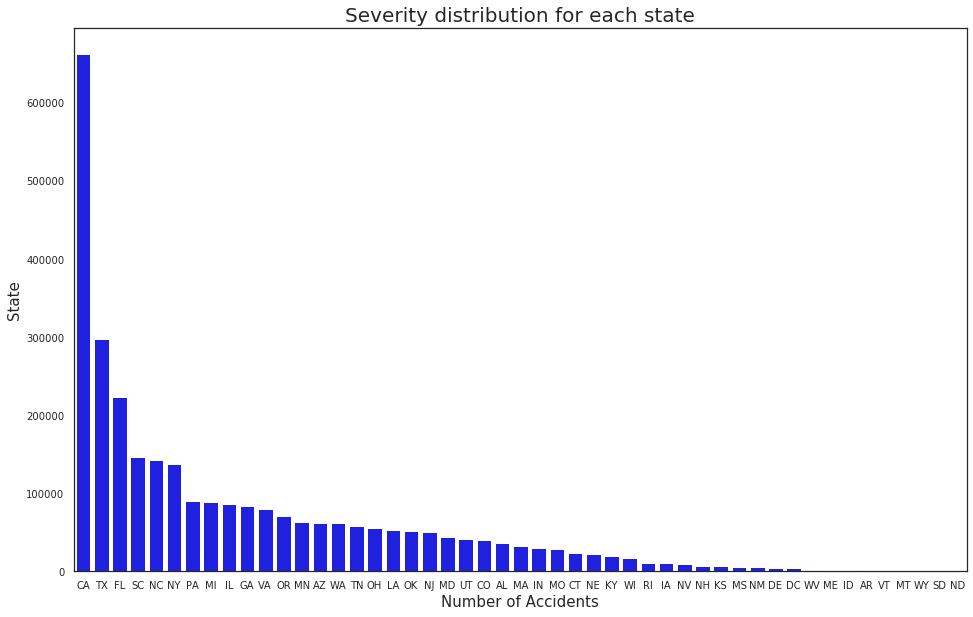

In [17]:
rdd = sc.parallelize(state_freq)
pd_states = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))
b = sns.barplot(pd_states['State'],pd_states['count'], color='blue')
b.axes.set_title("Severity distribution for each state",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("State",fontsize=15)
b.tick_params(labelsize=10)

In [18]:
state_severity_freq = df.groupBy('State','Severity').count().orderBy('count',ascending=False).collect()

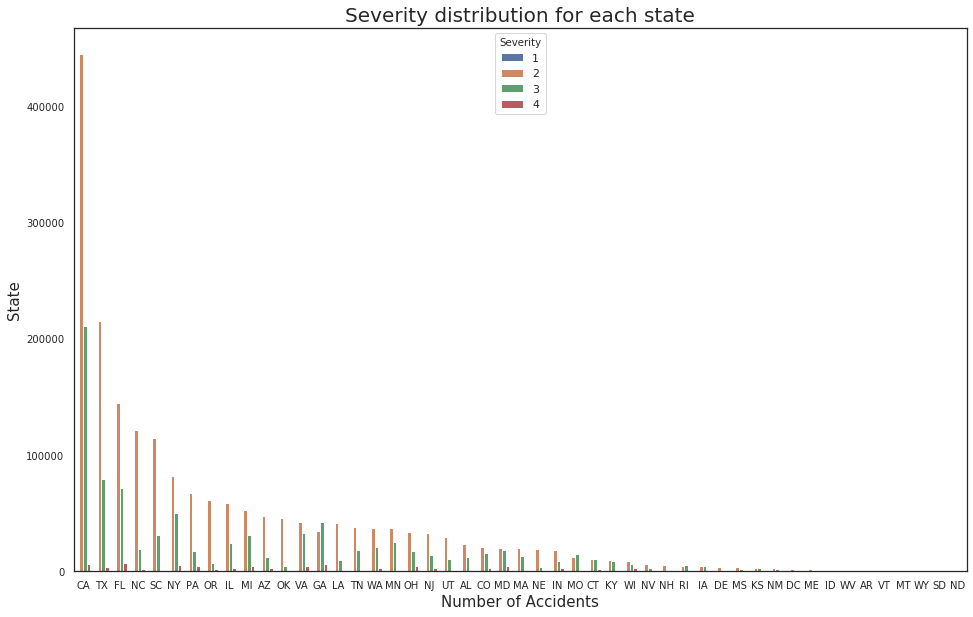

In [19]:
rdd = sc.parallelize(state_severity_freq)
pd_state_severity = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))
b = sns.barplot(x="State", y="count", hue="Severity", data=pd_state_severity)
#b = sns.barplot(pd_state_severity['State', 'Severity'],pd_state_severity['count'])
b.axes.set_title("Severity distribution for each state",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("State",fontsize=15)
b.tick_params(labelsize=10)

### Weather conditions

In [20]:
weather_freq = df.groupBy('Weather_Condition').count().orderBy('count',ascending=False).collect()

[Row(Weather_Condition='Clear', count=808171), Row(Weather_Condition='Mostly Cloudy', count=412528), Row(Weather_Condition='Overcast', count=382480), Row(Weather_Condition='Fair', count=335289), Row(Weather_Condition='Partly Cloudy', count=295439), Row(Weather_Condition='Scattered Clouds', count=204662), Row(Weather_Condition='Light Rain', count=141073), Row(Weather_Condition='Cloudy', count=115496), Row(Weather_Condition=None, count=65932), Row(Weather_Condition='Light Snow', count=42123), Row(Weather_Condition='Haze', count=34315), Row(Weather_Condition='Rain', count=32826), Row(Weather_Condition='Fog', count=22138), Row(Weather_Condition='Heavy Rain', count=12064), Row(Weather_Condition='Light Drizzle', count=10277), Row(Weather_Condition='Light Thunderstorms and Rain', count=4928), Row(Weather_Condition='Snow', count=4796), Row(Weather_Condition='Thunderstorm', count=4438), Row(Weather_Condition='Fair / Windy', count=3759), Row(Weather_Condition='Smoke', count=3602)]


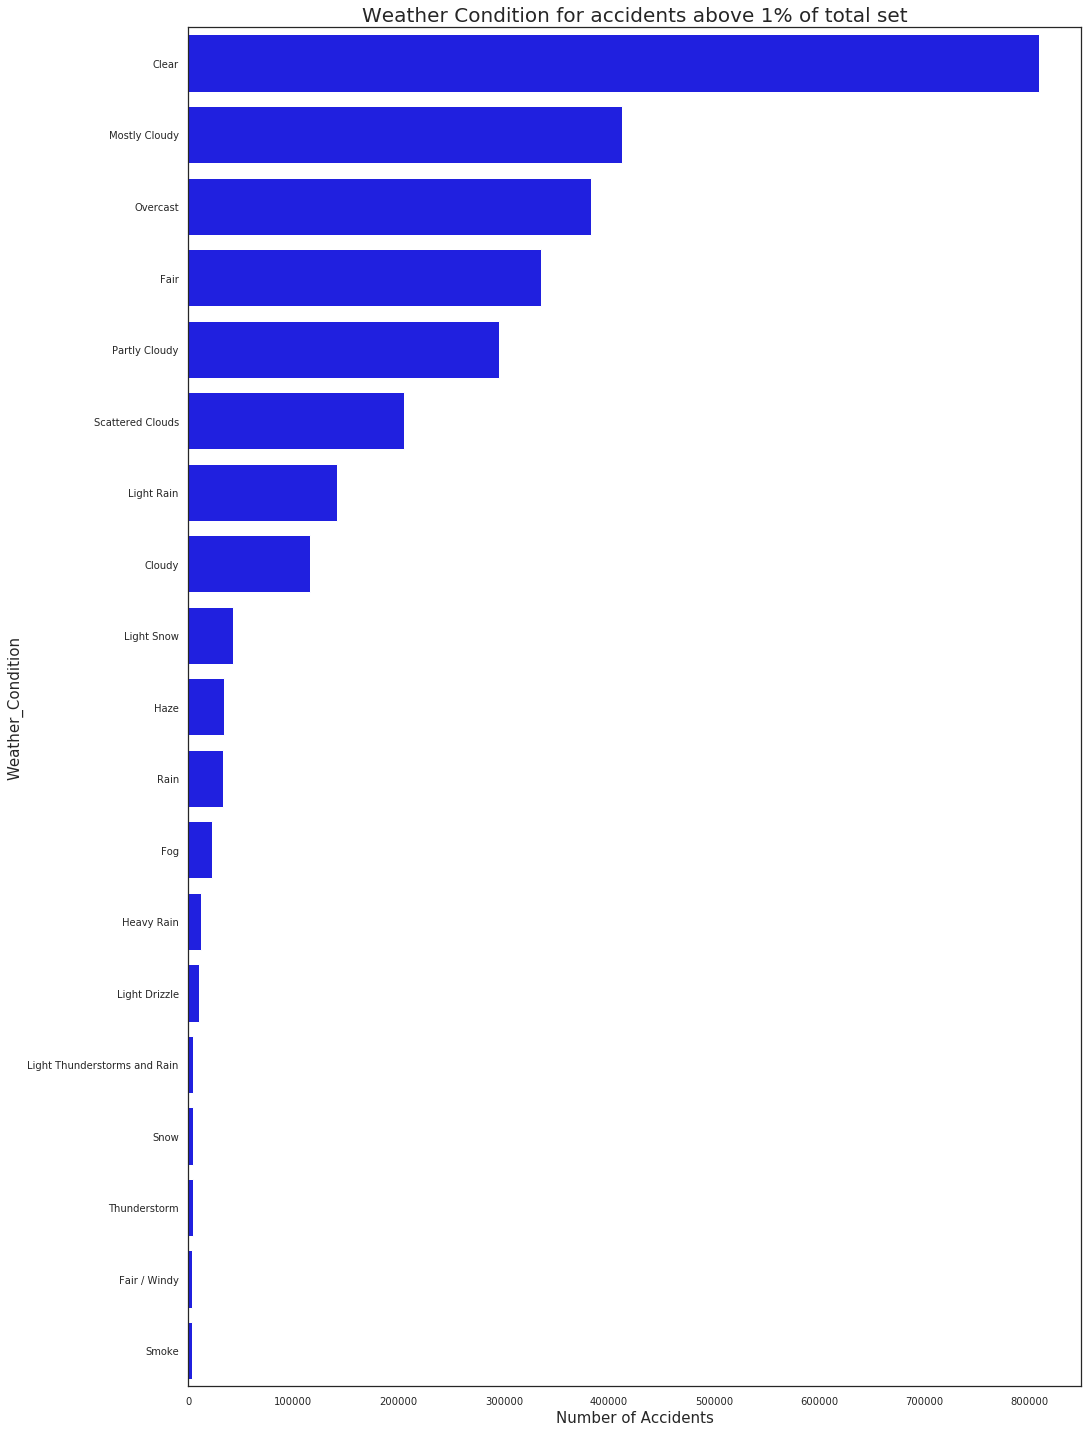

In [21]:
#display_limit = 12 # Limit on how many objects that should be displayed

fig, ax=plt.subplots(figsize=(16,25))
n = int(df.count()*0.001) # Limit the plot to ignore conditions below an limit

rdd = sc.parallelize(weather_freq)
rdd_filtered = rdd.filter(lambda x: x['count'] > n)
print(rdd_filtered.collect())


pd_weather = rdd_filtered.toDF().toPandas()

b = sns.barplot(pd_weather['count'][:],pd_weather['Weather_Condition'][:], color="blue")

b.axes.set_title("Weather Condition for accidents above 1% of total set",fontsize=20)
b.set_xlabel("Number of Accidents",fontsize=15)
b.set_ylabel("Weather_Condition",fontsize=15)
b.tick_params(labelsize=10)
plt.show()


In [22]:
# How severe was the condition for each type of weather?

### Time when accidents occured

In [23]:
df_time = df.selectExpr("hour(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False).collect()

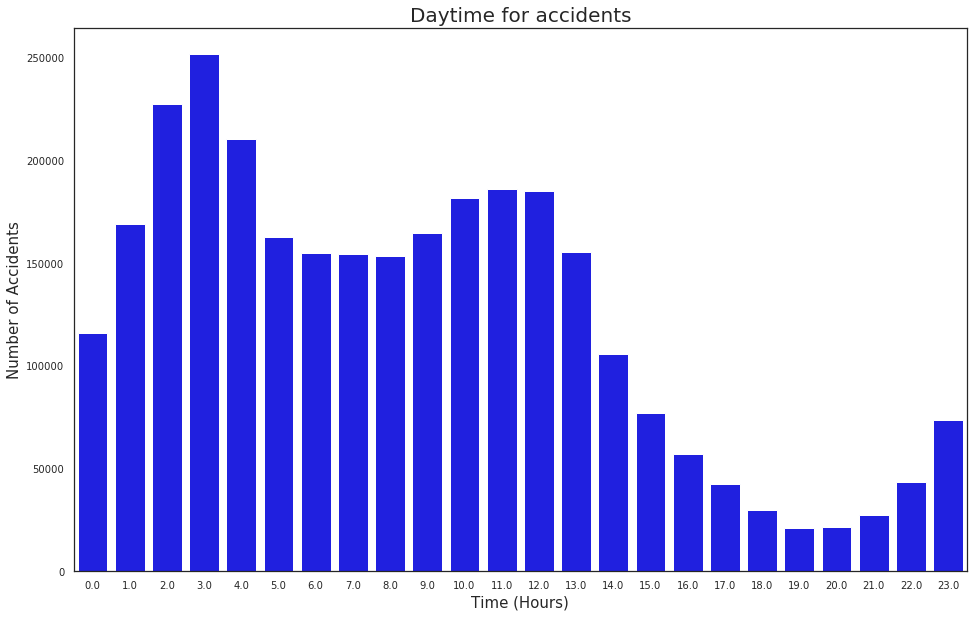

In [24]:
rdd = sc.parallelize(time_freq)
pd_time = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))

b = sns.barplot(pd_time['Start_Time'],pd_time['count'], color='blue')
b.axes.set_title("Daytime for accidents",fontsize=20)
b.set_xlabel("Time (Hours)",fontsize=15)
b.set_ylabel("Number of Accidents",fontsize=15)
b.tick_params(labelsize=10)
plt.show()


### Development of accidents on Month basis

In [25]:
df_time = df.selectExpr("month(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False).collect()

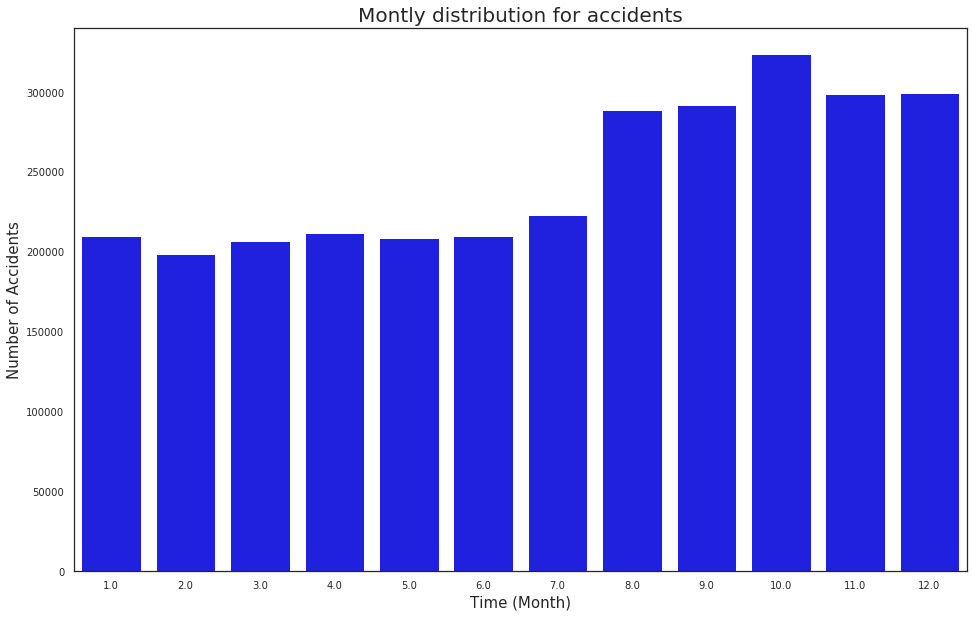

In [26]:
rdd = sc.parallelize(time_freq)
pd_time = rdd.toDF().toPandas()

# Plot data
fig,ax = plt.subplots(figsize=(16,10))

b = sns.barplot(pd_time['Start_Time'],pd_time['count'], color='blue')
b.axes.set_title("Montly distribution for accidents",fontsize=20)
b.set_xlabel("Time (Month)",fontsize=15)
b.set_ylabel("Number of Accidents",fontsize=15)
b.tick_params(labelsize=10)
plt.show()


### Map distribution

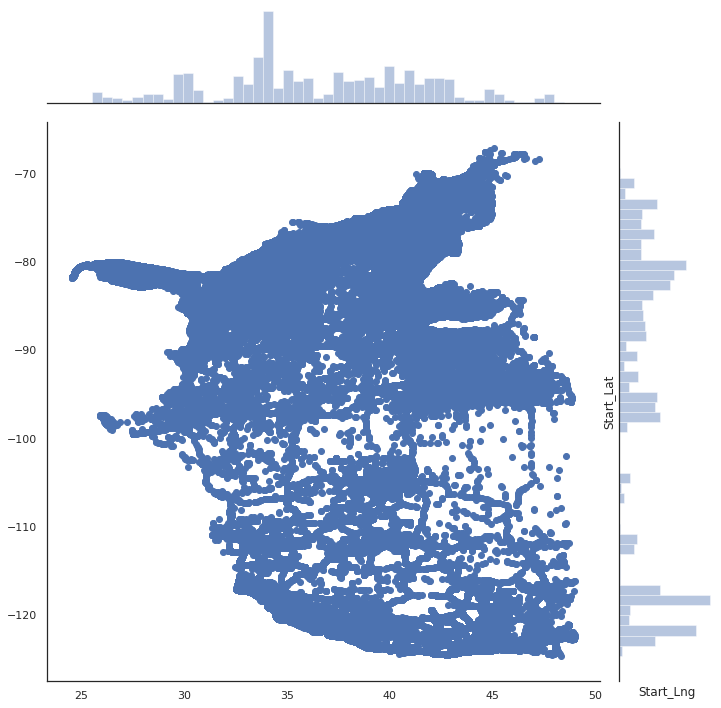

In [27]:
sns.jointplot(x=df.select(collect_list('Start_Lat')).first()[0],y=df.select(collect_list('Start_Lng')).first()[0],height=10)
plt.ylabel('Start_Lat', fontsize=12)
plt.xlabel('Start_Lng', fontsize=12)
plt.show()

In [28]:
import plotly.graph_objects as go

df_st_ct = df.groupBy('State').count().orderBy('count',ascending=False).collect()

fig = go.Figure(data=go.Choropleth(
    locations=df_st_ct['State'],
    z = df_st_ct['State'],  # Data to be color-coded
    locationmode = 'USA-states',     # set of locations match entries in `locations`
    colorscale = 'YlOrRd',
    colorbar_title = "Count",
))

fig.update_layout(
    title_text = 'US Accidents by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
from pyspark.ml.feature import PCA
# PCA - Not very good for categorical values
#pca_assembler = VectorAssembler(inputCols=df.columns, outputCol="pca_features",handleInvalid="skip")
#pca_df = pca_assembler.transform(df)
#print(pca_df)
#pca = PCA(k=5, inputCol="pca_features", outputCol="pcaFeatures")
#model = pca.fit(pca_df)

#result = model.transform(pca_features).select("pcaFeatures")
#result.show(truncate=False)